<a href="https://colab.research.google.com/github/Maiasamberger/QM2/blob/main/Copy_of_QM2project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install cdsapi xarray netcdf4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00


In [ ]:
# Downloading data with API key
from pathlib import Path

CDS_URL = "https://cds.climate.copernicus.eu/api"
CDS_KEY = "4df0da0b-1e16-4777-bcb2-e80161da680d"

config_text = f"""url: {CDS_URL}
key: {CDS_KEY}
"""

Path.home().joinpath(".cdsapirc").write_text(config_text)

print("CDS API credentials written successfully.")


CDS API credentials written successfully.


In [ ]:
import cdsapi

c = cdsapi.Client()

UK_AREA = [61, -8, 49, 2]  # North, West, South, East

# Jan–Dec 2025 --> lets only focus on year to make it easier and consistent
# & easier to justify date range rather than random dates - later to just only take the reddit comments from 2025


c.retrieve(
    "reanalysis-era5-land",
    {
        "variable": "surface_solar_radiation_downwards",
        "year": "2025",
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],
        "time": "00:00",
        "area": UK_AREA,
        "format": "netcdf",
    },
    "/content/era5_land_uk_ssrd_2025_jan_dec.nc",
)

print("Downloads complete.")


2026-01-08 05:27:08,223 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
INFO:ecmwf.datastores.legacy_client:[2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2026-01-08 05:27:08,226

f0928c7fdffb3f53a619808697da46f4.zip:   0%|          | 0.00/5.71M [00:00<?, ?B/s]

Downloads complete.


In [ ]:
!ls -lh /content | grep era5_land_uk_ssrd


-rw-r--r-- 1 root root 5.8M Jan  8 18:11 era5_land_uk_ssrd_2025_jan_dec.nc


In [ ]:
!file /content/era5_land_uk_ssrd_2025_jan_dec.nc


/content/era5_land_uk_ssrd_2025_jan_dec.nc: Zip archive data, at least v2.0 to extract, compression method=deflate


In [ ]:
# debugging code
!unzip -o /content/era5_land_uk_ssrd_2025_jan_dec.nc -d /content/era5_2025_unzipped


Archive:  /content/era5_land_uk_ssrd_2025_jan_dec.nc
  inflating: /content/era5_2025_unzipped/data_0.nc  


In [ ]:
!ls -lh /content/era5_2025_unzipped


total 5.8M
-rw-r--r-- 1 root root 5.8M Jan  4 22:58 data_0.nc


In [ ]:
import glob
import xarray as xr
import pandas as pd

# Find the extracted 2025 NetCDF
nc_2025 = glob.glob("/content/era5_2025_unzipped/*.nc")[0]

# Open dataset
ds = xr.open_dataset(nc_2025, engine="netcdf4")

print(ds)




<xarray.Dataset> Size: 18MB
Dimensions:     (valid_time: 364, latitude: 121, longitude: 101)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2025-01-01 ... 2025-12-30
  * latitude    (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude   (longitude) float64 808B -8.0 -7.9 -7.8 -7.7 ... 1.7 1.8 1.9 2.0
    number      int64 8B ...
    expver      (valid_time) <U4 6kB ...
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 18MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-04T22:58 GRIB to CDM+CF via cfgrib-0.9.1...


In [ ]:
# Save 2025 file

import os, glob, shutil

shutil.copy(nc_2025, "/content/era5_land_uk_ssrd_2025_jan_dec_extracted.nc")

print("Saved extracted NetCDF file with clean name.")


Saved extracted NetCDF file with clean name.


In [ ]:
# Step 2 — Make a clean daily UK series

# this is the final code after debugging

ssrd = ds["ssrd"]

# Rename valid_time to a clean date variable foe easier handling
ssrd = ssrd.rename({"valid_time": "date"})
ssrd["date"] = pd.to_datetime(ssrd["date"].values)

# Collapse unnecessary ERA5 internal dimensions (and take the non-missing values)
if "expver" in ssrd.dims:
    ssrd = ssrd.max(dim="expver", skipna=True)

# Drop number column
if "number" in ssrd.dims:
    ssrd = ssrd.isel(number=0, drop=True)

# make sure all unnecessary bookkeeping coordinates are dropped - including confusing time column
for coord in ["expver", "number", "time"]:
    if coord in ssrd.coords:
        ssrd = ssrd.reset_coords(coord, drop=True)

print("Dims after cleanup:", ssrd.dims)

Dims after cleanup: ('date', 'latitude', 'longitude')


ERA5-Land metadata variables related to model production (e.g. experiment version and forecast reference time) were removed prior to analysis. Only the observation-valid timestamp was retained to construct the daily time series.

In [ ]:
# Find mean and fix units and store in local variables

# Take UK-wide daily mean across grid cells - spatial average across UK
uk_daily = ssrd.mean(dim=["latitude", "longitude"], skipna=True)

# Convert J/m² → MJ/m²
uk_daily_mj = (uk_daily / 1e6).rename("sun_mj_m2")

# sanity check that all 2025 values are there

print("Missing days:", uk_daily_mj.isnull().sum().item())
print(
    "Date range:",
    uk_daily_mj["date"].min().values,
    "to",
    uk_daily_mj["date"].max().values
)

# this lets us know there is no 31st of December
# more sanity checks to ensure all data has been cleaned properly

print(uk_daily_mj.dims)
print(uk_daily_mj.sizes)
print(list(uk_daily_mj.coords))


Missing days: 0
Date range: 2025-01-01T00:00:00.000000000 to 2025-12-30T00:00:00.000000000
('date',)
Frozen({'date': 364})
['date']


In [ ]:
# Convert series to DataFrame for easier grouping

sun_df = uk_daily_mj.to_dataframe(name="sun_mj_m2").reset_index()

# Ensure clean date handling (covert to DateTime and sort dates consecutively
sun_df["date"] = pd.to_datetime(sun_df["date"])
sun_df = sun_df.sort_values("date").reset_index(drop=True)

# sanity check data frame and no missing values

print("Rows:", len(sun_df))
print("NaNs:", sun_df["sun_mj_m2"].isna().sum())

sun_df.head()


Rows: 364
NaNs: 0


,date,sun_mj_m2
0,2025-01-01,1.494090
1,2025-01-02,1.313197
2,2025-01-03,3.015605
3,2025-01-04,3.014390
4,2025-01-05,1.755478


In [ ]:
# Add day-of-year and year

sun_df["doy"] = sun_df["date"].dt.dayofyear

sun_df.head()


,date,sun_mj_m2,doy
0,2025-01-01,1.494090,1
1,2025-01-02,1.313197,2
2,2025-01-03,3.015605,3
3,2025-01-04,3.014390,4
4,2025-01-05,1.755478,5


In [ ]:
# check for duplicates

sun_df["date"].is_unique
sun_df["doy"].is_unique


True

In [ ]:
# code for lags

# Ensure correct ordering
sun_df = sun_df.sort_values("date").reset_index(drop=True)

# Create 1-day lag
sun_df["sun_lag1"] = sun_df["sun_mj_m2"].shift(1)

# Rolling 7-day mean (captures sustained exposure)
sun_df["sun_roll7"] = sun_df["sun_mj_m2"].rolling(7).mean()

sun_df.head(10)




,date,sun_mj_m2,doy,sun_lag1,sun_roll7
0,2025-01-01,1.494090,1,NaN,NaN
1,2025-01-02,1.313197,2,1.494090,NaN
2,2025-01-03,3.015605,3,1.313197,NaN
3,2025-01-04,3.014390,4,3.015605,NaN
4,2025-01-05,1.755478,5,3.014390,NaN
5,2025-01-06,0.837778,6,1.755478,NaN
6,2025-01-07,2.198619,7,0.837778,1.947022
7,2025-01-08,2.860606,8,2.198619,2.142239
8,2025-01-09,2.192642,9,2.860606,2.267874
9,2025-01-10,3.254767,10,2.192642,2.302040


Including a small number of lags:

*   aligns with theoretical mechanism (exposure → mood → language)
*   shows temporal awareness
*  does not overcomplicate the model

Recommended set (clean + interpretable):

*   same day (sun_mj_m2)
*   lag 1 day
*   rolling 7-day mean

This will introduce NaNs in the first few rows — that’s expected and correct.

You will drop these rows later, when you build the regression dataset.

In [ ]:
# Create calander variables that will be used to control regression later

# These will become:
# month fixed effects
# day-of-week fixed effects

sun_df["month"] = sun_df["date"].dt.month
sun_df["dow"] = sun_df["date"].dt.dayofweek  # Monday=0


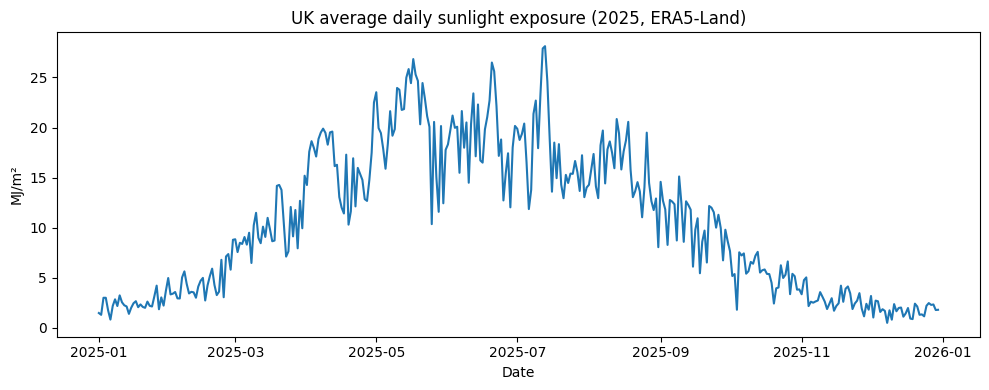

In [ ]:
# sunlight visual 1 - Daily UK sunlight over time - you can spice up later

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(sun_df["date"], sun_df["sun_mj_m2"])
plt.title("UK average daily sunlight exposure (2025, ERA5-Land)")
plt.xlabel("Date")
plt.ylabel("MJ/m²")
plt.tight_layout()
plt.show()


Fig 1 shows:


*  visually anchors your independent variable
*   shows seasonality clearly
*   gives intuition for magnitude and variation

In [ ]:
# Fun map visual of UK sunlight - uses monthly UK mean rather than daily so it runs smoothly
# This takes every a monthly mean of every single radiation sensor in the Uk
# Make an interactive heatmap
# Make better later - eg add coastline or render directly onto satellite basemap

!pip -q install netcdf4 xarray plotly

import glob
import numpy as np
import pandas as pd
import xarray as xr
import plotly.graph_objects as go

# --- Load 2025 file ---
nc_2025 = glob.glob("/content/era5_2025_unzipped/*.nc")[0]
ds = xr.open_dataset(nc_2025, engine="netcdf4")

da = ds["ssrd"]

# Use real calendar axis
if "valid_time" in da.dims:
    da = da.rename({"valid_time": "date"})
elif "time" in da.dims:
    da = da.rename({"time": "date"})

da["date"] = pd.to_datetime(da["date"].values)

# Collapse ERA5 internal dimensions
if "expver" in da.dims:
    da = da.max(dim="expver", skipna=True)
if "number" in da.dims:
    da = da.isel(number=0, drop=True)

lat_name = "latitude" if "latitude" in da.dims else "lat"
lon_name = "longitude" if "longitude" in da.dims else "lon"

# Convert to MJ/m^2 and monthly mean
sun = (da / 1e6).rename("sun_mj_m2")
sun_m = sun.resample(date="1MS").mean()

# Zoom to UK box
uk_lat_min, uk_lat_max = 49.5, 61.5
uk_lon_min, uk_lon_max = -8.5, 2.5

# Handle latitude direction
if sun_m[lat_name][0] > sun_m[lat_name][-1]:
    sun_m = sun_m.sel({lat_name: slice(uk_lat_max, uk_lat_min), lon_name: slice(uk_lon_min, uk_lon_max)})
else:
    sun_m = sun_m.sel({lat_name: slice(uk_lat_min, uk_lat_max), lon_name: slice(uk_lon_min, uk_lon_max)})

# Ensure lat ascending for Plotly
if sun_m[lat_name][0] > sun_m[lat_name][-1]:
    sun_m = sun_m.sortby(lat_name)

dates = sun_m["date"].values
lats  = sun_m[lat_name].values
lons  = sun_m[lon_name].values

zmin = float(sun_m.min().values)
zmax = float(sun_m.max().values)

# Initial frame
z0 = sun_m.isel(date=0).values

fig = go.Figure(
    data=[go.Heatmap(
        z=z0, x=lons, y=lats,
        zsmooth="best",          # makes it look less pixelated
        coloraxis="coloraxis"
    )],
    layout=go.Layout(
        title="UK sunlight exposure (ERA5-Land SSRD) — monthly mean (MJ/m²), 2025",
        xaxis=dict(title="Longitude", range=[uk_lon_min, uk_lon_max]),
        yaxis=dict(title="Latitude", range=[uk_lat_min, uk_lat_max]),
        coloraxis=dict(cmin=zmin, cmax=zmax),
        height=650, width=750,
        updatemenus=[dict(
            type="buttons", showactive=False,
            buttons=[
                dict(label="Play", method="animate", args=[None, {"frame": {"duration": 600, "redraw": True}, "fromcurrent": True}]),
                dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0}, "mode": "immediate"}])
            ]
        )]
    ),
    frames=[
        go.Frame(
            data=[go.Heatmap(
                z=sun_m.isel(date=i).values, x=lons, y=lats,
                zsmooth="best",
                coloraxis="coloraxis"
            )],
            name=str(pd.to_datetime(dates[i]).date())
        )
        for i in range(len(dates))
    ]
)

fig.update_layout(
    sliders=[dict(
        steps=[dict(method="animate",
                    args=[[str(pd.to_datetime(d).date())],
                          {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    label=str(pd.to_datetime(d).date()))
               for d in dates],
        currentvalue={"prefix": "Date: "}
    )]
)

fig.show()


This heatmap shows that taking a UK daily average of sulight is justifiable - better to compare UK to UK than taking a city as a proxy and comparing that to the whole of UK.

In [ ]:
# Save sun exposure DF as cleaned CSV to use for merging later


sun_df.to_csv("/content/uk_daily_sunlight_2025_clean.csv", index=False)

LATER WHAT WE CAN ADD FOR ROBUSTNESS IS either
1) Robustness check with full population grid (strongest, more work)

2) Robustness check with 4 nations weighting of populations

Nest step: adding the reddit comments ....

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bwandowando/reddit-rcasualuk-subreddit-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.47G/9.47G [04:12<00:00, 40.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bwandowando/reddit-rcasualuk-subreddit-dataset/versions/383


In [ ]:
import os, re
import pandas as pd

csv_path = os.path.join(path, "casualuk_subreddit_comments.csv")

df = pd.read_csv(csv_path, usecols=["created_utc", "body", "score"])

# Parse datetime (assumes created_utc is already a datetime string)
df["date"] = pd.to_datetime(df["created_utc"], errors="coerce")
df = df.dropna(subset=["date", "body"])

# Day as pandas datetime (clean for grouping/merging)
df["day"] = df["date"].dt.floor("D")

# Filter to 2025 (and optionally stop at 2025-12-30 later)
df_2025 = df[(df["day"] >= "2025-01-01") & (df["day"] <= "2025-12-30")].copy()

# Basic text cleaning (VADER-friendly: don't remove stopwords)
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)     # URLs
    text = text.replace("&amp;", "and")
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_2025["clean_text"] = df_2025["body"].apply(clean_text)

# Remove trivial/empty comments
df_2025 = df_2025[df_2025["clean_text"].str.len() > 3].copy()

print("Earliest:", df_2025["day"].min())
print("Latest:", df_2025["day"].max())
print("Unique days:", df_2025["day"].nunique())
print("Rows:", len(df_2025))

# Daily comment volume (useful diagnostic + later control)
daily_counts = (
    df_2025.groupby("day")
    .size()
    .reset_index(name="comment_count")
    .sort_values("day")
)

daily_counts.head()


Earliest: 2025-01-01 00:00:00
Latest: 2025-12-30 00:00:00
Unique days: 364
Rows: 1135544


,day,comment_count
0,2025-01-01,3468
1,2025-01-02,3163
2,2025-01-03,2250
3,2025-01-04,3140
4,2025-01-05,3467


In [ ]:
# sanity check

print(df_2025.sort_values("date")[["created_utc","date","day"]].head(3))
print(df_2025.sort_values("date")[["created_utc","date","day"]].tail(3))



                 created_utc                date        day
1161133  2025-01-01 00:00:31 2025-01-01 00:00:31 2025-01-01
1161132  2025-01-01 00:00:37 2025-01-01 00:00:37 2025-01-01
1161131  2025-01-01 00:00:59 2025-01-01 00:00:59 2025-01-01
               created_utc                date        day
12082  2025-12-30 23:58:54 2025-12-30 23:58:54 2025-12-30
12081  2025-12-30 23:59:16 2025-12-30 23:59:16 2025-12-30
12080  2025-12-30 23:59:22 2025-12-30 23:59:22 2025-12-30


In [ ]:
# sanity check

full_days = pd.date_range(df_2025["day"].min(), df_2025["day"].max(), freq="D")
missing = full_days.difference(daily_counts["day"])
print("Missing days:", len(missing))


Missing days: 0


Note: The analysis period is restricted to 1 Jan–30 Dec 2025 to ensure exact temporal overlap with the environmental exposure data.

In [ ]:
# initialise VADER

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Comment-level sentiment scoring
# Apply VADER to the already cleaned text:

df_2025["vader"] = df_2025["clean_text"].apply(
    lambda x: sid.polarity_scores(x)["compound"]
)


In [ ]:
# sanity check

df_2025["vader"].describe()


,vader
count,1.135544e+06
mean,1.286269e-01
std,4.465812e-01
min,-9.999000e-01
25%,0.000000e+00
50%,0.000000e+00
75%,4.767000e-01
max,9.996000e-01


<Axes: >

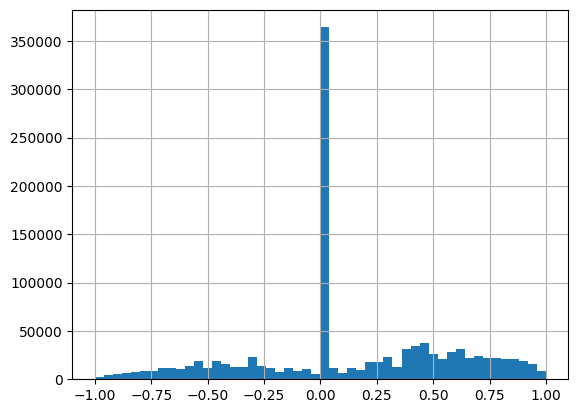

In [ ]:
# sanity check

df_2025["vader"].hist(bins=50)


The distribution of comment-level VADER scores exhibits substantial mass at neutrality alongside long positive and negative tails, consistent with prior analyses of online discourse and motivating the use of sentiment extremity rather than directional averages.

In [ ]:
# Convert sentiment to extremity
# Define extremity

df_2025["extremity"] = df_2025["vader"].abs()


Interpretation:



*   0 --> neutral
*   1 --> maximally emotional
*   because "abs" = absolute value - direction is ignored (i.e. positivity or negativity)








In [ ]:
# sanity check

df_2025["extremity"].describe()


,extremity
count,1.135544e+06
mean,3.464010e-01
std,3.098159e-01
min,0.000000e+00
25%,0.000000e+00
50%,3.400000e-01
75%,5.994000e-01
max,9.999000e-01


In [ ]:
# Aggregate to daily extremity
daily_extremity = (
    df_2025
    .groupby("day")["extremity"]
    .mean()
    .reset_index()
    .sort_values("day")
)


We now have:


*   one row per day
*   average emotional intensity of discourse that day



In [ ]:
# Check

print(daily_extremity.head())
print(daily_extremity.tail())

         day  extremity
0 2025-01-01   0.345976
1 2025-01-02   0.361722
2 2025-01-03   0.366226
3 2025-01-04   0.359680
4 2025-01-05   0.346665
           day  extremity
359 2025-12-26   0.386810
360 2025-12-27   0.385289
361 2025-12-28   0.375751
362 2025-12-29   0.384814
363 2025-12-30   0.371680


We dont need to control for volume of comments yet (i.e. the fact that dif days will have different numbers of comments)

By taking the mean extremity per day we are already:

*   normalising by number of comments
*   avoiding “more comments = more extremity” mechanically

So daily extremity answers:

“How emotionally intense was the average comment today?”

Volume can matter if:


*   very low-volume days are noisy
*   viral days distort averages


We will handle this later by:


*   adding comment_count as a control, or
*   weighting regressions, or
*   doing a robustness check excluding very low-volume days





In [ ]:
# We can run diagnostic now to tell us if volume is even a concern. This is not modelling, just inspection.

# merge in the daily comment counts we computed

daily_sent = daily_extremity.merge(
    daily_counts, on="day", how="left"
)

daily_sent[["extremity", "comment_count"]].corr()


,extremity,comment_count
extremity,1.000000,-0.168742
comment_count,-0.168742,1.000000


The diagnostic tells us correlation is -0.17

This is a WEAK negative correlation and not a cause for concern, we just mention in writeup that we have checkerd.

Rule of thumb:

|r| < 0.2 → weak

|r| 0.2–0.4 → moderate

|r| > 0.5 → strong

A weak negative correlation implies:
On days with more comments, the average emotional intensity per comment is slightly lower.

This makes intuitive sense:

High-volume days often include:

*   lots of short replies
*   factual updates
*   neutral engagement


Low-volume days may have:

*   fewer but more emotionally charged comments


This does NOT imply a data problem.



Daily sentiment extremity is weakly negatively correlated with comment volume (r ≈ −0.17), suggesting that high-activity days tend to include a larger share of neutral discourse. To ensure results are not driven by fluctuations in posting volume, we assess robustness to controlling for daily comment counts.

In [ ]:
# code we cld maybe use later for volume control

# X = sm.add_constant(df[["sun_mj_m2", "comment_count"]])

MOVING ONTO MERGING THE TWO DATASETS

In [ ]:
# Step 1: Making sure the date columns are compatible
# We want both to be pandas datetimes at daily frequency

# Ensure datetime type
daily_extremity["day"] = pd.to_datetime(daily_extremity["day"])
sun_df["date"] = pd.to_datetime(sun_df["date"])


In [ ]:
# sanity check

print(daily_extremity["day"].dtype)
print(sun_df["date"].dtype)


datetime64[ns]
datetime64[ns]


In [ ]:
# Step 2️2:  Rename for a clean merge key
# We will use the same column name (day) in both

sun_df = sun_df.rename(columns={"date": "day"})


In [ ]:
# Step 3: Inner merge

df_merged = daily_extremity.merge(
    sun_df[[
        "day",
        "sun_mj_m2",
        "sun_lag1",
        "sun_roll7",
        "doy"
    ]],
    on="day",
    how="inner"
).sort_values("day")

An inner join ensures we only keep days where both:

*   Reddit extremity exists
*   Sunlight data exists




In [ ]:
# Important alignment diagnostics

# Date range
print("Merged earliest:", df_merged["day"].min())
print("Merged latest:", df_merged["day"].max())

# number of days
print("Number of merged days:", len(df_merged))

# check for missing days explicitly

full_days = pd.date_range(
    df_merged["day"].min(),
    df_merged["day"].max(),
    freq="D"
)

missing_days = full_days.difference(df_merged["day"])

print("Missing days:", len(missing_days))
missing_days[:5]




Merged earliest: 2025-01-01 00:00:00
Merged latest: 2025-12-30 00:00:00
Number of merged days: 364
Missing days: 0


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

YAY ALL GOOD ! - full dataset when merged

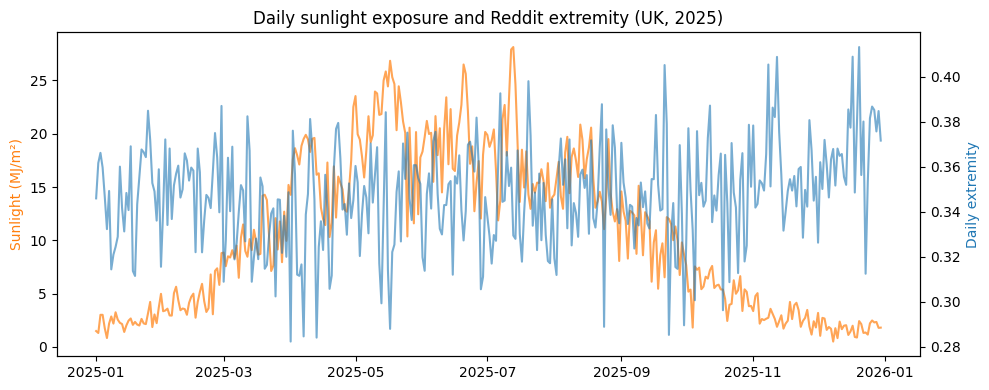

In [ ]:
# CORE VISUAL: Dual axis time series
# this is also a visual sanity check

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(
    df_merged["day"],
    df_merged["sun_mj_m2"],
    color="tab:orange",
    alpha=0.7
)
ax1.set_ylabel("Sunlight (MJ/m²)", color="tab:orange")

ax2 = ax1.twinx()
ax2.plot(
    df_merged["day"],
    df_merged["extremity"],
    color="tab:blue",
    alpha=0.6
)
ax2.set_ylabel("Daily extremity", color="tab:blue")

plt.title("Daily sunlight exposure and Reddit extremity (UK, 2025)")
plt.tight_layout()
plt.show()



NOTE - the above figure is not an inference just a diagnostic to ensure correct merge. And it passes all the tests!



*  two smooth, continuous time series
*  two smooth, continuous time series
*   two smooth, continuous time series
*   sunlight showing strong seasonality





Caption for fig above: Daily UK sunlight exposure and Reddit sentiment extremity (2025). Both series exhibit strong seasonal variation, motivating regression analysis.

This is a really important visual. It shows:



*  How sunlight and extremity move over time
*  Makes the seasonal relationship immediately visible
*  Visually motivates why month fixed effects matter



In [ ]:
# lets do a correlation matrix again - remember high correlation expected

sun_vars = [
    "sun_mj_m2",
    "sun_lag1",
    "sun_roll7",
    "doy"
]

df_merged[sun_vars].corr()


,sun_mj_m2,sun_lag1,sun_roll7,doy
sun_mj_m2,1.000000,0.930604,0.947150,-0.174666
sun_lag1,0.930604,1.000000,0.958229,-0.169919
sun_roll7,0.947150,0.958229,1.000000,-0.189454
doy,-0.174666,-0.169919,-0.189454,1.000000


Correlations > 0.8 → red flag for multicollinearity

We expect:

sun_mj_m2 ↔ sun_lag1 → high

sun_mj_m2 ↔ sun_roll7 → moderate–high

sun_* ↔ doy → strong seasonal correlation

This is expected, not a problem — we just don’t put everything in one regression.

Correlation reults very important interpretations:


1. Very high multicollinearity among sunlight measures
*   Same-day, 1-day lag, and 7-day rolling mean are almost the same signal

*  Including more than one of these in the same regression would: inflate standard errors, make coefficients unstable, weaken interpretability.

*   This is textbook multicollinearity and tells us we must NOT use them together



2. doy correlation is modest (~ −0.18)

This means:

*   doy captures seasonality, not daily variation
*   it can be used later as a control or fixed effect proxy
*   But it should not be in the same model as multiple sunlight terms





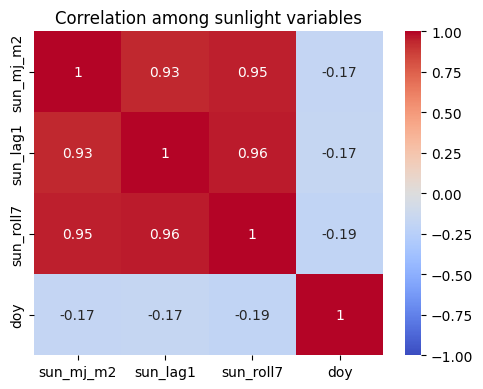

In [ ]:
# Correlation heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(
    df_merged[sun_vars].corr(),
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1
)
plt.title("Correlation among sunlight variables")
plt.tight_layout()
plt.show()


SO based of this, our modelling choices:

Main specification we use: sun_mj_m2 (same-day exposure)

Secondary dynamic specification use sun_lag1 to test delayed effect hypothesis and avoid collinearity - do not use seven day lag as well, only one is necessary

Seasonality:

We can use either month fixed effects OR smooth time controls (doy)

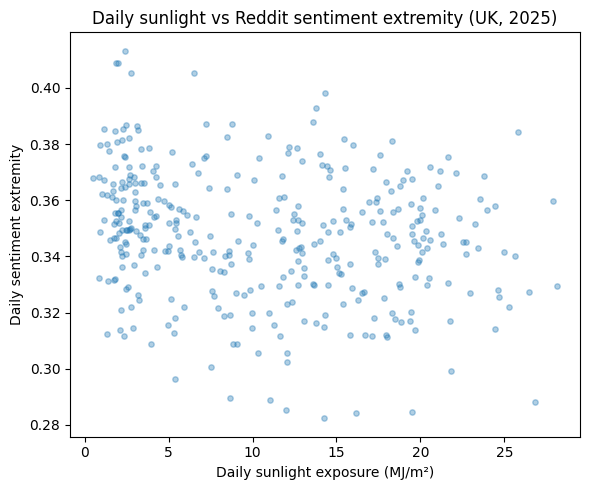

In [ ]:
# Exploratory visual before regression

# Scatter plot of extremity vs same-day sunlight

# Helps us:
# 1. visualise the relationship
# 2. spot outliers or nonlinearity
# 3. justify the linear model choice --> why we will do the linear regression

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.scatter(
    df_merged["sun_mj_m2"],
    df_merged["extremity"],
    alpha=0.35,
    s=15
)

plt.xlabel("Daily sunlight exposure (MJ/m²)")
plt.ylabel("Daily sentiment extremity")
plt.title("Daily sunlight vs Reddit sentiment extremity (UK, 2025)")

plt.tight_layout()
plt.show()




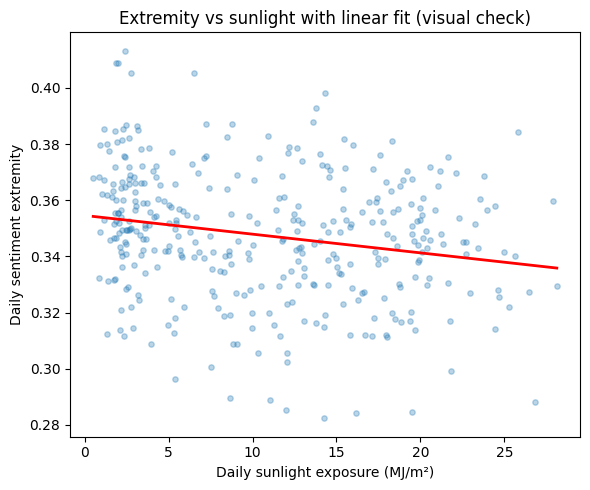

In [ ]:
import numpy as np

x = df_merged["sun_mj_m2"].values
y = df_merged["extremity"].values

# Simple linear fit for visual guidance
coef = np.polyfit(x, y, 1)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = coef[0] * x_fit + coef[1]

plt.figure(figsize=(6,5))

plt.scatter(x, y, alpha=0.3, s=15)
plt.plot(x_fit, y_fit, color="red", linewidth=2)

plt.xlabel("Daily sunlight exposure (MJ/m²)")
plt.ylabel("Daily sentiment extremity")
plt.title("Extremity vs sunlight with linear fit (visual check)")

plt.tight_layout()
plt.show()


Slight slope downwards = consistent with our theory that less sunlight --> higher extremity. Results are noisy but regression may still detect relatioship statistcially. So it is appropriate to proceed with regression.

A scatter plot of daily sentiment extremity against sunlight exposure suggests a weak but systematic relationship, motivating formal regression analysis. Slight downward trend + lots of noise is textbook case for regression with robust inference.

Baseline regression

Extremityt​=α+β⋅Sunlightt​+εt​

In [ ]:
import statsmodels.api as sm

# Define variables
X = df_merged[["sun_mj_m2"]]
X = sm.add_constant(X)

y = df_merged["extremity"]

# OLS with heteroskedasticity-robust standard errors
model = sm.OLS(y, X).fit(cov_type="HC3")

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              extremity   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     18.32
Date:                Thu, 08 Jan 2026   Prob (F-statistic):           2.39e-05
Time:                        18:24:15   Log-Likelihood:                 868.12
No. Observations:                 364   AIC:                            -1732.
Df Residuals:                     362   BIC:                            -1724.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3546      0.002    176.248      0.0

Interpretation:

A one-unit increase in daily sunlight exposure (1 MJ/m²) is associated with a 0.0007 decrease in average daily sentiment extremity.



*   The negative sign matches your theory:
→ less sunlight → higher emotional extremity
*   The effect is statistically significant at conventional levels.
*  The confidence interval excludes zero → this is not noise.




| Statistic   | Value             |
| ----------- | ----------------- |
| Coefficient | **−0.0007**       |
| Std. error  | small             |
| z-stat      | −4.28             |
| p-value     | **< 0.001**       |
| 95% CI      | entirely negative |


Effect size:

0.0007 is small — but that is completely expected.



*  Our dependent variable is an average across ~1 million comments
*  Our independent variable is a physical exposure measured daily
*  Social behaviour is noisy




A small marginal effect with high confidence is exactly what we expect in population-level behavioural data.

"The estimated effect is modest in magnitude but precisely estimated."

R-squared = 0.045

This means: Sunlight explains about 4.5% of the day-to-day variation in extremity.

This is normal for social data and not a sign of a weak or invalid member.



Diagnistics:

Durbin–Watson ≈ 1.62
→ mild positive autocorrelation (expected in time series, not alarming)


Omnibus / JB tests
→ residuals look approximately normal


Condition number ≈ 23
→ no multicollinearity issues


EVERYTHING ALL GOOD - NO ISSUES

We can safely conclude: Daily sunlight exposure is negatively associated with the emotional extremity of UK Reddit discourse, with lower sunlight days exhibiting more emotionally intense comments on average.

For those who are writing up - REMEMBER this is correlation NOT causation esp bcs the reddit comments arent technically filtered to the UK, we are just using a UK focused reddit forum.

NEXT: controlling for seasonality

We are going to use month fixed effects instead of the "day of year" column we made. Doy wld be more appropriate with multiple years.

Month fixed effects = flexible, interpretable, robust

DOY = restrictive, assumption-heavy

Explanation:

"Seasonality is controlled for using month fixed effects, which allow for flexible, non-parametric differences across calendar months without imposing assumptions about the functional form of seasonal variation."



In [ ]:
# create month fixed effects
# We already have "day" as DateTime. We’ll extract month as a categorical variable, then create dummies.

# Create month variable
df_merged["month"] = df_merged["day"].dt.month

# Create month fixed effects (drop one to avoid dummy trap)
month_dummies = pd.get_dummies(df_merged["month"], prefix="month", drop_first=True)

# Combine with main dataframe
df_fe = pd.concat([df_merged, month_dummies], axis=1)


In [ ]:
# run the regression with month fixed effects

import pandas as pd
import statsmodels.api as sm

# 1) Month as categorical
df_merged["month"] = df_merged["day"].dt.month.astype("category")

# 2) Dummies as integers (0/1), not objects
month_dummies = pd.get_dummies(df_merged["month"], prefix="month", drop_first=True, dtype=int)

# 3) Build X and force numeric
X = pd.concat([df_merged[["sun_mj_m2"]], month_dummies], axis=1)
X = sm.add_constant(X)

# 4) Ensure endog is numeric too
y = pd.to_numeric(df_merged["extremity"], errors="coerce")

# 5) Final safety: drop any rows with NaNs in X or y
data = pd.concat([y.rename("extremity"), X], axis=1).dropna()
y_clean = data["extremity"]
X_clean = data.drop(columns=["extremity"])

print("X dtypes:\n", X_clean.dtypes.head())
print("N obs used:", len(data))

model_fe = sm.OLS(y_clean, X_clean).fit(cov_type="HC3")
print(model_fe.summary())



X dtypes:
 const        float64
sun_mj_m2    float32
month_2        int64
month_3        int64
month_4        int64
dtype: object
N obs used: 364
                            OLS Regression Results                            
Dep. Variable:              extremity   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.650
Date:                Thu, 08 Jan 2026   Prob (F-statistic):           5.04e-07
Time:                        18:24:15   Log-Likelihood:                 885.49
No. Observations:                 364   AIC:                            -1745.
Df Residuals:                     351   BIC:                            -1694.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.0

Interpreting these results:

Daily sunlight exposure is negatively associated with sentiment extremity in aggregate. However, when controlling for month-level seasonality, this association attenuates and becomes statistically insignificant, suggesting that the relationship is primarily driven by broader seasonal variation rather than short-run daily fluctuations.

The baseline model uses both seasonal and daily variation in sunlight; once the seasonal component is removed by month fixed effects, the residual day-to-day sunlight variation within a month does not show a clear relationship with extremity.

An R² of 0.132 means the model explains about 13.2% of the day-to-day variation in extremity. Importantly, this R² is substantially higher than our baseline model’s R² (≈ 0.045), indicating that month fixed effects capture a significant portion of variation in extremity—consistent with strong seasonal/calendar patterns.

Chatgpt summary you guys can use:

Regression model 2: Month Fixed Effects

In the baseline model, daily sunlight exposure is negatively associated with sentiment extremity. However, when month fixed effects are included to absorb broad seasonal differences, the estimated association attenuates and becomes statistically insignificant (β = −0.0005, p = 0.317). This indicates that the baseline relationship is largely driven by seasonal co-variation between sunlight and discourse intensity (winter versus summer), rather than by short-run day-to-day sunlight fluctuations within months. Consistent with this, the inclusion of month fixed effects improves model fit (R² = 0.132 vs. ≈0.045 in the baseline model), and late-year month indicators (e.g., November and December) are associated with higher baseline extremity relative to January (November: +0.0127, p = 0.012; December: +0.0204, p < 0.001). Overall, the results suggest that “raw” sunlight primarily proxies for seasonal structure in both environmental exposure and discourse behaviour.

/tmp/ipython-input-369602007.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




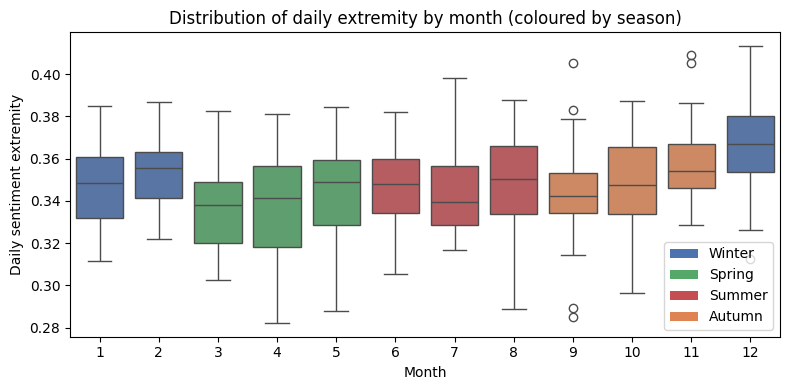

In [ ]:
# Month Fixed Effects visual boxplots

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# create a season variable
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df_merged["season"] = df_merged["month"].apply(month_to_season)

# define season colour palette

season_palette = {
    "Winter": "#4C72B0",  # blue
    "Spring": "#55A868",  # green
    "Summer": "#C44E52",  # red
    "Autumn": "#DD8452"   # orange
}


# Build month → colour mapping in correct order
month_order = sorted(df_merged["month"].unique())
month_colors = [
    season_palette[df_merged.loc[df_merged["month"] == m, "season"].iloc[0]]
    for m in month_order
]

# Plot boxplots with seasonal colouring
fig, ax = plt.subplots(figsize=(8, 4))

sns.boxplot(
    x="month",
    y="extremity",
    data=df_merged,
    order=month_order,
    palette=month_colors,
    ax=ax
)

ax.set_xlabel("Month")
ax.set_ylabel("Daily sentiment extremity")
ax.set_title("Distribution of daily extremity by month (coloured by season)")

# Add legend
legend_elements = [
    Patch(facecolor=season_palette[s], label=s)
    for s in ["Winter", "Spring", "Summer", "Autumn"]
]

ax.legend(
    handles=legend_elements,
    loc="lower right",
    frameon=True
)

plt.tight_layout()
plt.show()


Months are colour-coded by meteorological season to visually emphasise the seasonal structure underlying variation in sentiment extremity.

/tmp/ipython-input-3751131256.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




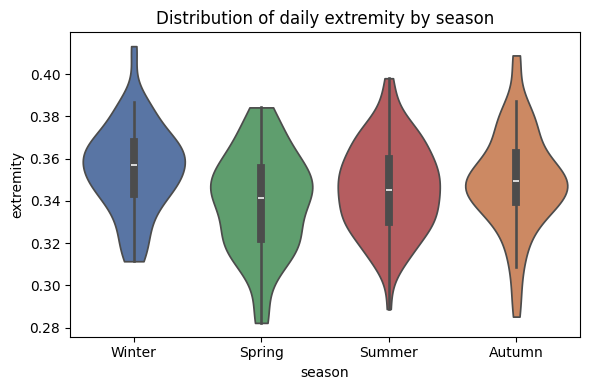

In [ ]:
# distribution comparison by season

plt.figure(figsize=(6,4))
sns.violinplot(
    x="season",
    y="extremity",
    data=df_merged,
    palette=season_palette,
    cut=0
)
plt.title("Distribution of daily extremity by season")
plt.tight_layout()
plt.show()


1. Directly visualises your seasonal finding
2. Violin plots show density, not just quartiles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def two_hist_ci_proportion(
    data,
    outcome,
    sunlight="sun_mj_m2",
    q=0.25,
    sample_size=1000,
    iterations=10000
):
    """
    Plot sampling distributions and 95% confidence intervals
    for a daily proportion outcome on low vs high sunlight days.
    """

    # Define low / high sunlight days
    low_cut  = data[sunlight].quantile(q)
    high_cut = data[sunlight].quantile(1 - q)

    low_group = data.loc[data[sunlight] <= low_cut, outcome].dropna()
    high_group = data.loc[data[sunlight] >= high_cut, outcome].dropna()

    groups = [low_group, high_group]
    labels = [
        "Low sunlight (bottom quartile)",
        "High sunlight (top quartile)"
    ]

    plt.figure(figsize=(15,6))

    it = -1
    for var in groups:
        it += 1
        sample_means = []

        for _ in range(iterations):
            sample = var.sample(sample_size, replace=True)
            sample_means.append(sample.mean())

        # Histogram of sampling distribution
        plt.hist(
            sample_means,
            bins=int(iterations / 300),
            density=True,
            edgecolor="white",
            label=labels[it]
        )

        # Normal approximation
        mu, se = norm.fit(sample_means)
        x = np.linspace(min(sample_means), max(sample_means), 100)
        plt.plot(x, norm.pdf(x, mu, se), linewidth=2)

        # Mean and ~95% CI
        plt.axvline(var.mean(), color="green", linewidth=3)
        plt.axvline(mu - 2*se, color="black", linestyle="dashed", linewidth=1.5)
        plt.axvline(mu + 2*se, color="black", linestyle="dashed", linewidth=1.5)

    plt.xlabel(f"Mean {outcome}")
    plt.title(
        f" Average emotional {outcome} with 95% confidence intervals\n"
        f"Low vs high sunlight days"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()




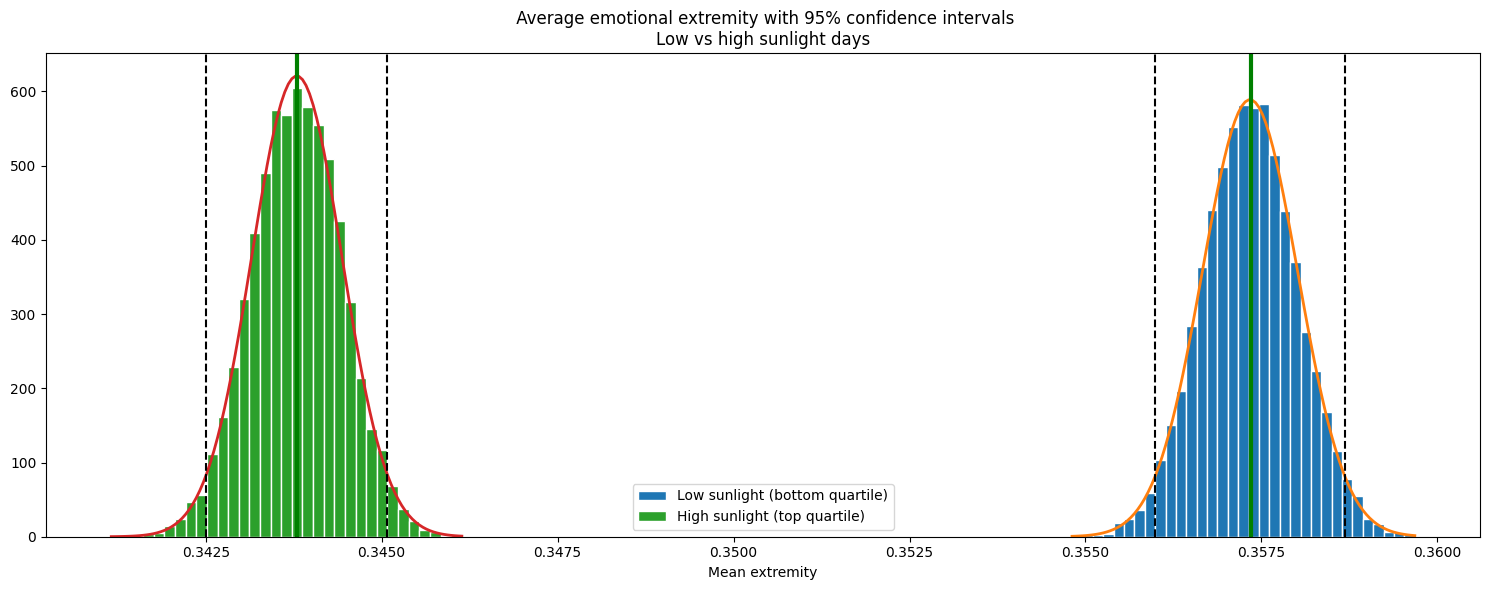

In [ ]:
two_hist_ci_proportion(
    data=df_merged,
    outcome="extremity"
)

The figure compares the distribution of emotional extremity on low-sunlight days (bottom quartile) and high-sunlight days (top quartile), with 95% confidence intervals around the mean.

Mean extremity is systematically higher on low-sunlight days than on high-sunlight days. The estimated means (solid vertical lines) are clearly separated, and the 95% confidence intervals do not overlap, indicating that the difference is statistically significant rather than due to sampling variability.

Substantively, this suggests that reduced sunlight exposure is associated with more emotionally extreme language, whereas higher sunlight days are associated with slightly more emotionally moderate discourse. Although the absolute difference in extremity is small in magnitude, the tight confidence intervals and clear separation indicate a robust and consistent effect across days.

NOW LASTLY LETS RUN LAGGED SUNLIGHT MODEL ....

Extremityt​=α+β⋅Sunlightt−1​+εt​

Key idea:

This tests whether yesterday’s sunlight is associated with today’s discourse extremity, which is plausible if mood or affective states adjust with a delay.


We do not include month fixed effects here — that would over-restrict the model and blur interpretation.

In [ ]:
# Run the lagged regression

# Because sun_lag1 has a missing value on the first day, we explicitly drop rows with NaNs

import statsmodels.api as sm

# Drop rows where lag is missing
df_lag = df_merged.dropna(subset=["sun_lag1"]).copy()

X = df_lag[["sun_lag1"]]
X = sm.add_constant(X)

y = df_lag["extremity"]

model_lag = sm.OLS(y, X).fit(cov_type="HC3")
print(model_lag.summary())


                            OLS Regression Results                            
Dep. Variable:              extremity   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     18.01
Date:                Thu, 08 Jan 2026   Prob (F-statistic):           2.80e-05
Time:                        18:24:16   Log-Likelihood:                 865.91
No. Observations:                 363   AIC:                            -1728.
Df Residuals:                     361   BIC:                            -1720.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3549      0.002    172.065      0.0

Interpretation:

The estimated coefficient on lagged sunlight is negative and statistically significant (β = −0.0007, p < 0.001), indicating that lower sunlight exposure on the previous day is associated with higher average sentiment extremity the following day. Substantively, a one-unit increase in sunlight exposure (1 MJ/m²) on day t − 1 is associated with a 0.0007 reduction in extremity on day t. While the magnitude of the effect is modest, as expected in population-level behavioural data, the estimate is precisely measured and robust. The model explains approximately 4.8 percent of the day-to-day variation in extremity (R² = 0.048), comparable to the baseline same-day model. Taken together, these results suggest that the association between sunlight and emotional intensity in online discourse is not purely contemporaneous, but may reflect a short-run delayed affective response to environmental conditions, consistent with theories of mood adjustment and affective carryover.

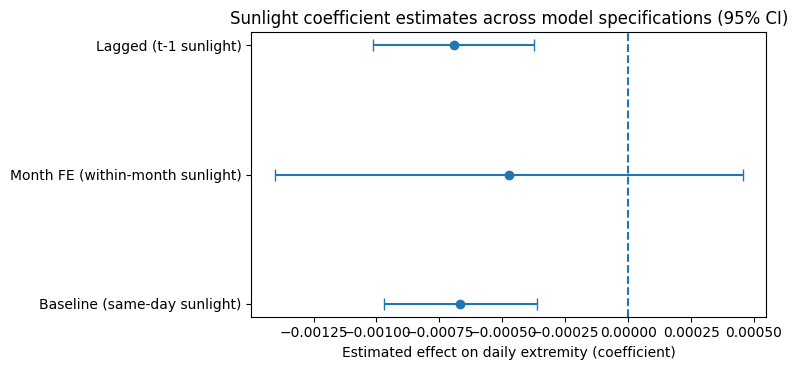

,Model,coef,ci_low,ci_high,p
0,Baseline (same-day sunlight),-0.000666,-0.000971,-0.000361,0.000019
1,Month FE (within-month sunlight),-0.000474,-0.001404,0.000455,0.316983
2,Lagged (t-1 sunlight),-0.000694,-0.001014,-0.000373,0.000022


In [ ]:
# coefficient plot

import pandas as pd
import matplotlib.pyplot as plt

# Map each model to the coefficient name we care about
coef_map = {
    "Baseline (same-day sunlight)": ("model", "sun_mj_m2"),
    "Month FE (within-month sunlight)": ("model_fe", "sun_mj_m2"),
    "Lagged (t-1 sunlight)": ("model_lag", "sun_lag1"),
}

# Helper: extract coef + CI from a statsmodels results object
def extract_coef_ci(res, varname):
    b = float(res.params[varname])
    lo, hi = res.conf_int().loc[varname]
    return b, float(lo), float(hi)

rows = []
for label, (res_name, varname) in coef_map.items():
    res = globals()[res_name]  # grabs model objects by name
    b, lo, hi = extract_coef_ci(res, varname)
    p = float(res.pvalues[varname])
    rows.append({"Model": label, "coef": b, "ci_low": lo, "ci_high": hi, "p": p})

coef_df = pd.DataFrame(rows)

# Order top-to-bottom as listed
coef_df["Model"] = pd.Categorical(coef_df["Model"], categories=list(coef_map.keys()), ordered=True)
coef_df = coef_df.sort_values("Model").reset_index(drop=True)

# y positions
ypos = range(len(coef_df))

# Plot
plt.figure(figsize=(8, 3.8))
plt.errorbar(
    x=coef_df["coef"],
    y=ypos,
    xerr=[coef_df["coef"] - coef_df["ci_low"], coef_df["ci_high"] - coef_df["coef"]],
    fmt="o",
    capsize=4
)

plt.axvline(0, linestyle="--")
plt.yticks(list(ypos), coef_df["Model"])
plt.xlabel("Estimated effect on daily extremity (coefficient)")
plt.title("Sunlight coefficient estimates across model specifications (95% CI)")
plt.tight_layout()
plt.show()

coef_df


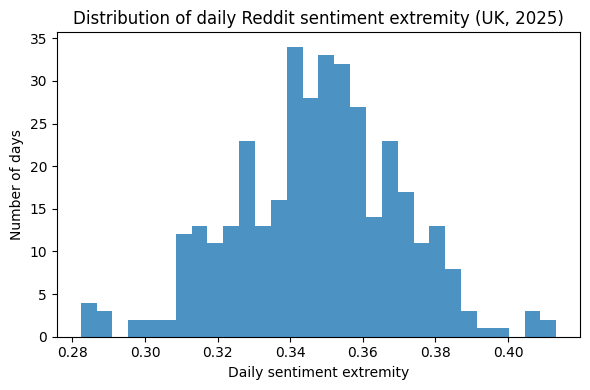

In [ ]:
# historgam of daily extremity - this has nothing to do with sunlight just a visualisation of extremity but kind of unnecessary

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df_merged["extremity"], bins=30, alpha=0.8)

plt.xlabel("Daily sentiment extremity")
plt.ylabel("Number of days")
plt.title("Distribution of daily Reddit sentiment extremity (UK, 2025)")
plt.tight_layout()
plt.show()

This justifies: using OLS on a daily mean
and interpreting coefficients as marginal effects

Daily extremity exhibits a unimodal distribution with moderate dispersion, supporting the use of linear regression on aggregated daily mean